In [40]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision

from diffusers.models import AutoencoderKL

from tinyimagenet import TinyImageNet

In [41]:
if(torch.cuda.is_available()):
    print("Using CUDA")
    device = torch.device('cuda')
else:
    print("Using CPU")
    device = torch.device('cpu')

# set seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

Using CUDA


In [42]:
# TinyImageNet

dataset = TinyImageNet('./data/tiny-imagenet-200', 'train')
data = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [54]:
def init_vae():
    # https://huggingface.co/stabilityai/sd-vae-ft-mse
    model: AutoencoderKL = AutoencoderKL.from_pretrained('stabilityai/sd-vae-ft-mse').to(device)
    # model = torch.compile(model) # TODO we should do this on linux for optimization
    model = model.eval()
    model.train = False
    for param in model.parameters():
        param.requires_grad = False
    return model

vae = init_vae()
scale_factor=0.18215 # scale_factor follows DiT and stable diffusion.

@torch.no_grad()
def load_img(path: str) -> torch.Tensor:
    img = torchvision.io.read_image(path).unsqueeze(0).to(device).to(torch.float32)
    img = (img / 127.5) - 1
    return img

@torch.no_grad()
def encode(x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]: 
    posterior = vae.encode(x, return_dict=False)[0].parameters
    return torch.chunk(posterior, 2, dim=1)    

@torch.no_grad()
def sample(mean: torch.FloatTensor, logvar: torch.FloatTensor) -> torch.FloatTensor:
    std = torch.exp(0.5 * logvar)
    z = torch.randn_like(mean)
    z = mean + z * std
    return z * scale_factor

@torch.no_grad()
def decode(z) -> torch.Tensor:
    x = vae.decode(z / scale_factor, return_dict=False)[0]
    x = torch.clamp((x + 1.0) / 2.0, min=0.0, max=1.0)
    return x

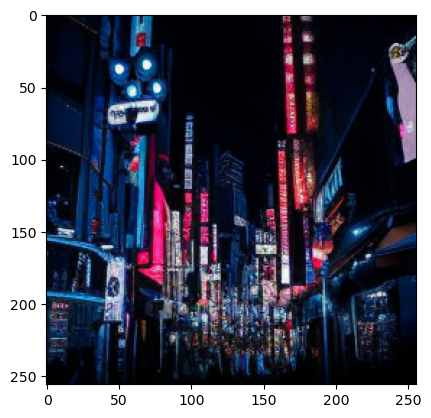

In [61]:

# Load test image (test_image.jpg)

image_real = load_img('test_image.jpg')
image_noise = torch.randn(1, 3, 256, 256).to(device)

# Encode the image

mean, logvar = encode(image_real)

# Store image in various formats

image_real_scaled = (image_real + 1.0) / 2.0

torchvision.utils.save_image(image_real_scaled, 'encoded.jpg')
torchvision.utils.save_image(image_real_scaled, 'encoded.png')
torchvision.utils.save_image(image_real_scaled, 'encoded.tiff')

meanF16 = mean.to(torch.float16).cpu().numpy()
logvarF16 = logvar.to(torch.float16).cpu().numpy()

np.savez_compressed('encoded.npz', m=meanF16, lv=logvarF16)

# Load the image back

mean = torch.from_numpy(np.load('encoded.npz')['m']).to(device).to(torch.float32)
logvar = torch.from_numpy(np.load('encoded.npz')['lv']).to(device).to(torch.float32)

# Sample from the posterior

z = sample(mean, logvar)

# Visualize the generated samples

x = decode(z)
x = x.detach().cpu().numpy()

plt.imshow(x[0].transpose(1, 2, 0))

plt.show()

